In [1]:
import tensorflow as tf
import os
import h5py
import numpy as np
import sys
sys.path.append('../data_generation')
from utils import onehot_to_seq,seq_to_onehot
from gopher.dinuc_shuffle import dinuc_shuffle
from sklearn import model_selection
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

count = 300

2024-02-29 10:25:50.494149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Systemetic search

In [4]:
model = tf.keras.models.load_model('../model/lenti_MPRA/lenti_MPRA_onehot/K562/base_CNN_model.h5')
top_x = np.load('../motif_id/top_seq/lenti_K562.npz')['arr_0']
top_saliency = np.load('../motif_id/top_saliency/CNN_lenti_K562.npz')['arr_1']
for i in range(500):
    seq = np.swapaxes(top_x[[i]],1,2)
    sal = top_saliency[i]
    threshold = np.sort(sal)[int(len(sal)*0.95)]
    selected_site = np.where(sal > threshold)[0]
    motif_loci = []
    for loci in selected_site:
        motif_loci.extend(list(range(loci-2,loci+3)))
        motif_loci = list(set(motif_loci))
    shuffle_seq = []
    for j in range(count):
        shuffle_seq.append(dinuc_shuffle(seq[0]))
    motif_seq = np.copy(shuffle_seq)
    motif_seq[:,motif_loci] = seq[0][motif_loci]
    wt_pred = model.predict(seq)[0]
    baseline_pred = model.predict(np.array(shuffle_seq))
    motif_pred = model.predict(motif_seq)
    break
    

/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


10/10 [==============================] - 0s 974us/step


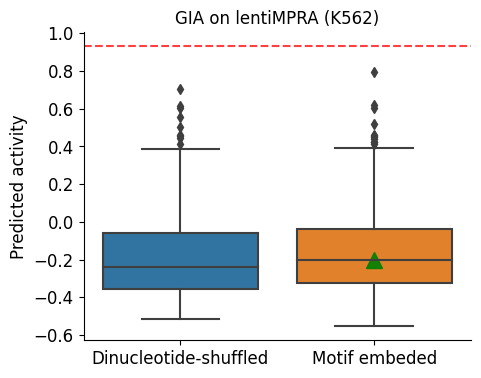

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=[baseline_pred,motif_pred])
ax.set_xticklabels(['Dinucleotide-shuffled','Motif embeded'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
plt.ylabel("Predicted activity",fontsize=12)
plt.title('GIA on lentiMPRA (K562)',fontsize=12)
plt.yticks(fontsize=12);
plt.xticks(fontsize=12);

plt.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [wt_pred,wt_pred], 'r--', alpha=0.75),
plt.plot([1],[np.median(motif_pred)],marker='^', alpha=0.9,color='green',markersize=12)

## Single example

In [2]:
model = tf.keras.models.load_model('../model/lenti_MPRA/lenti_MPRA_onehot/K562/base_CNN_model.h5')

top_x = np.load('../motif_id/top_seq/lenti_K562.npz')['arr_0']
top_x = np.swapaxes(top_x[[384]],1,2)[0]
shuffle_seq = []
for i in range(count):
    shuffle_seq.append(dinuc_shuffle(top_x))
shuffle_seq = np.array(shuffle_seq)

wt_pred = model.predict(np.array([top_x]))
baseline_pred = model.predict(shuffle_seq)

2024-02-29 10:25:58.693035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78973 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:47:00.0, compute capability: 8.0
/home/ztang/.conda/envs/jax_tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
2024-02-29 10:25:59.975064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-29 10:26:00.075086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


10/10 [==============================] - 0s 6ms/step


In [3]:
p_1 = 'ACTTCCGCC'
p_2 = 'GATTGGATTGG'
p_3 = 'AGCCAATCA'

o1 = seq_to_onehot(p_1)
o2 = seq_to_onehot(p_2)
o3 = seq_to_onehot(p_3)

#motif added sequence
motif_seq = np.copy(shuffle_seq)
motif_seq[:,19:28,:] = o1
motif_seq[:,104:115,:] =o2
motif_seq[:,148:157,:] = o3

cnn_pred = model.predict(motif_seq)

10/10 [==============================] - 0s 874us/step


In [4]:
p_1 = 'ACTTCCGCC'
p_2 = 'GTTCCCAGCAT'
p_3 = 'AGCCAATCA'

o1 = seq_to_onehot(p_1)
o2 = seq_to_onehot(p_2)
o3 = seq_to_onehot(p_3)

#motif added sequence
motif_seq = np.copy(shuffle_seq)
motif_seq[:,19:28,:] = o1
motif_seq[:,148:157,:] = o3
motif_seq[:,207:218,:] = o2

gpn_pred = model.predict(motif_seq)

10/10 [==============================] - 0s 873us/step


In [5]:
from scipy import stats
## P value calculation
p_value = stats.mannwhitneyu(baseline_pred,cnn_pred)
print(p_value)

p_value = stats.mannwhitneyu(gpn_pred,cnn_pred)
print(p_value) 

MannwhitneyuResult(statistic=array([1266.]), pvalue=array([2.80105469e-94]))
MannwhitneyuResult(statistic=array([25772.]), pvalue=array([1.34843533e-19]))


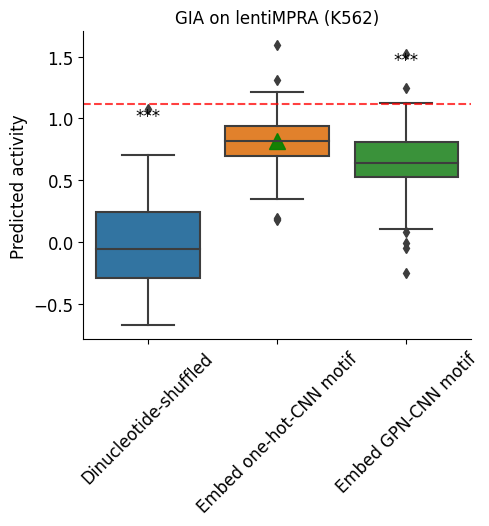

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
sns.boxplot(data=[baseline_pred,cnn_pred,gpn_pred])
ax.set_xticklabels(['Dinucleotide-shuffled','Embed one-hot-CNN motif','Embed GPN-CNN motif'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
plt.ylabel("Predicted activity",fontsize=12)
plt.title('GIA on lentiMPRA (K562)',fontsize=12)
plt.yticks(fontsize=12);
plt.xticks(rotation=45,fontsize=12);

plt.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [wt_pred[0],wt_pred[0]], 'r--', alpha=0.75),
plt.plot([1],[np.median(cnn_pred)],marker='^', alpha=0.9,color='green',markersize=12)

plt.text(0, 0.95, "***", ha='center', va='bottom', color='k', fontsize=12)
plt.text(2, 1.4, "***", ha='center', va='bottom', color='k', fontsize=12)

plt.savefig('../figure/GIA.svg')